# Predicting Marvel Movie Ratings from YouTube Comments

Kevin Nolasco

Cabrini University

MCIS565 - Natural Language Processing

05/13/2022

![MarvelRatings_Flow.jpg](MarvelRatings_Flow.jpg)

## Load Data

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter, defaultdict
from wordcloud import WordCloud
from PIL import Image
from textblob import TextBlob

In [253]:
df_comments = pd.read_json('data/movie_comments.json')
df_ratings = pd.read_json('data/movie_ratings.json')

## EDA

First we will inspect the comments dataset and clean it so we can use it later.

Since our data is taken from YouTube comments, there is a chance that we see repeated comments; the repeated comments could be considered spam and will will remove them.

In [254]:
# inspect the duplicated comments
df_comments[df_comments.duplicated(['CommentAuthor', 'OriginalComment'])].tail()

,MovieName,MovieId,CommentAuthor,OriginalComment
90388,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90389,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90390,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90391,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟
90392,Spider-Man: No Way Home,ZYzbalQ6Lg8,UC4eL8LDWE75VraK9UfSlonQ,Malayalam please 😟😟😟


In [255]:
# remove the duplicates
df_comments.drop_duplicates(subset = ['CommentAuthor', 'OriginalComment'], inplace = True, keep = False)
df_comments.head()

,MovieName,MovieId,CommentAuthor,OriginalComment
0,Iron Man,8ugaeA-nMTc,UCQzG9JFe87-FrpMAVZjX_Kg,honestly this is still the best marvel movie imo
1,Iron Man,8ugaeA-nMTc,UC1bmGHVTIBOerbW2P-pJsog,2:10 2:11
2,Iron Man,8ugaeA-nMTc,UC7A-gvQcpTmkBs1c0FJU92Q,This just shows the whole movie lmao😂
3,Iron Man,8ugaeA-nMTc,UC4r37ZNp-chrosonJ2VsdEg,14 years
4,Iron Man,8ugaeA-nMTc,UC0QY_nzoJvlb5z-dfwnVGsA,2:14


Now let's see how many comments are left, we will check for duplicates once more to ensure the duplicates are gone.

In [256]:
# drop duplicates if any
n_rows_comments = df_comments.shape[0]
n_rows_comments_deduped = df_comments.drop_duplicates(subset = ['CommentAuthor', 'OriginalComment']).shape[0]
print("""
Number of rows in dataset : {}
Number of rows deduped : {}
""".format(n_rows_comments, n_rows_comments_deduped))


Number of rows in dataset : 89336
Number of rows deduped : 89336



Let's see some simple statistics for our dataset.

- How many comments total?
- How many comment authors?
- How many movies?
- Which movie has the most comments?
- What is the average number of comments per movie?
- How many character are the shortest and longest comments?
- What is the average number of characters per comment?

In [257]:
# answering the questions above
n_comments = df_comments.shape[0]
n_comment_authors = df_comments['CommentAuthor'].nunique()
n_movies = df_comments['MovieName'].nunique()
movie_with_most_comments, most_comments_count = df_comments.groupby(by = 'MovieName').size()\
    .sort_values(ascending = False).reset_index(name = 'comment_count').iloc[0].values
avg_number_of_comments = int(df_comments.groupby(by = 'MovieName').size().mean())

df_comments['comment_length'] = df_comments['OriginalComment'].apply(lambda comment: len(comment))
shortest_comment_len, longest_comment_len, avg_comment_len = df_comments['comment_length'].min(), df_comments['comment_length'].max(), df_comments['comment_length'].mean() 

print("""
Dataset Stats:\n
{:,} comments\n
{:,} comment authors\n
{} unique movies\n
"{}" contains the most comments - ({:,} comments)\n
On average, the movies in the dataset contain {:,} comments\n
The shortest comment contains {} characters\n
The longest comment contains {:,} characters\n
The average number of characters per comment is {:,.0f}\n
""".format(n_comments, n_comment_authors, n_movies, \
    movie_with_most_comments, most_comments_count, \
        avg_number_of_comments, shortest_comment_len,\
            longest_comment_len, avg_comment_len))


Dataset Stats:

89,336 comments

77,533 comment authors

26 unique movies

"Black Widow" contains the most comments - (4,005 comments)

On average, the movies in the dataset contain 3,436 comments

The shortest comment contains 0 characters

The longest comment contains 34,594 characters

The average number of characters per comment is 75




In [258]:
# let's see the statistics for comment length
df_comments['comment_length'].describe(percentiles = [0.5, 0.75, 0.95])

count    89336.000000
mean        74.990664
std        191.434816
min          0.000000
50%         46.000000
75%         82.000000
95%        219.000000
max      34594.000000
Name: comment_length, dtype: float64

By looking at the percentile above, we can see that only 5% of the comments have length greater than 219 characters. We'll filter the data to include comments with characters <= 220. Let's try to find a cut-off point for the minimum number of characters.

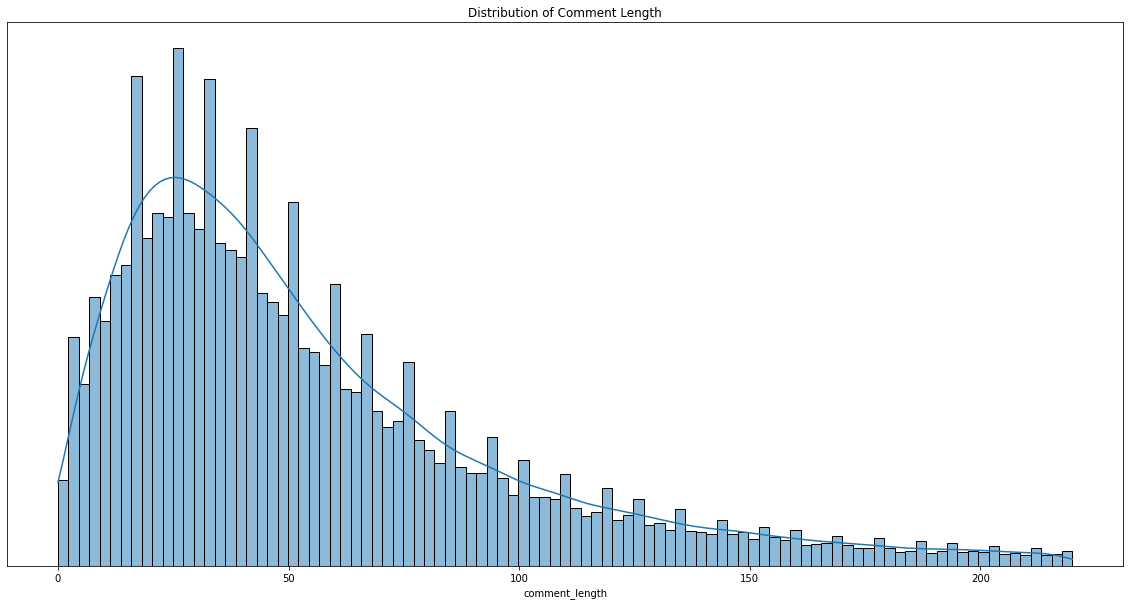

In [259]:
# function to help plot
def create_plots(rows = 1, cols = 1):
    fig, axs = plt.subplots(rows, cols)
    fig.set_size_inches(20,10)
    return fig, axs

def clean_plot(axs, g, title):
    """
    remove ticks, add title, add counts above bars, remove grid lines
    """
    plt.tick_params(left = False, bottom = False , labelbottom = False)
    g.set(ylabel = None, xlabel = None, title = title)
    g.bar_label(g.containers[0], labels = ['{:,.0f}'.format(val) for val in g.containers[0].datavalues])
    axs.grid(False)

filtered = df_comments[df_comments['comment_length'] <= 220]
fig, axs = create_plots()
g = sns.histplot(data = filtered, x = 'comment_length', kde = True, ax  = axs, palette = 'deep')
g.set(ylabel = None, title = 'Distribution of Comment Length')
plt.tick_params(left = False, labelleft = False)
plt.show()

We can see that the comment length is heavily right skewed. I want to avoid keeping comments with 1 character since it won't contribute to the sentiment score. Instead, let's define at threshold of 10 characters or more.

In [260]:
df_comments = df_comments[(df_comments['comment_length'] >= 10) & (df_comments['comment_length'] <= 220)]

## Plot for Comments By Movies

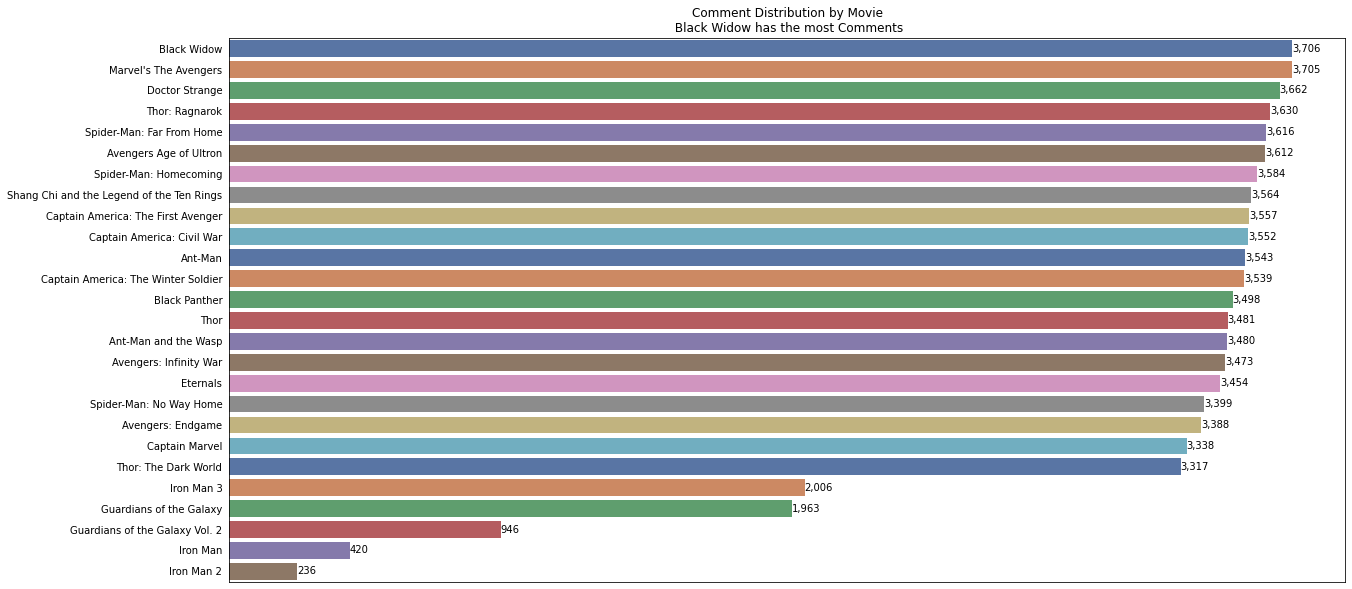

In [261]:
fig, axs = create_plots()
g = sns.countplot(data = df_comments, y = 'MovieName', order = df_comments['MovieName'].value_counts().index, \
    palette = 'deep')
clean_plot(axs, g, 'Comment Distribution by Movie\n Black Widow has the most Comments')
plt.show()

## Plot for most Frequently Used Words

In [262]:
# let's see what the top 20 most common words are
Counter(' '.join(df_comments['OriginalComment']).lower().split()).most_common(20)

[('the', 36639),
 ('this', 21334),
 ('i', 20785),
 ('is', 16714),
 ('movie', 13555),
 ('in', 13292),
 ('to', 13261),
 ('a', 12958),
 ('and', 12329),
 ('of', 11312),
 ('it', 8960),
 ('was', 7955),
 ('trailer', 6647),
 ('that', 6623),
 ('for', 6131),
 ('you', 5568),
 ('so', 5308),
 ('like', 5068),
 ('marvel', 4888),
 ('after', 4842)]

## Data Cleaning

From above, we can see the most common word is "the". That's not very helpful, so we will remove the stop words from the dataset.

In order to conserve the meaning of the sentences, we will perform lemmatization using NLTK before removing stopwords in order to capture the correct POS. Since the purpose of this project is to find the sentiment of the comments, we will keep the stopwords in new column of the dataframe but remove them in another.

In [263]:
class CommentCleaner:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.pos_map = defaultdict(lambda: 'n')
        self.pos_map.update({'VB' : 'v',
                            'VBD' : 'v',
                            'VBG' : 'v',
                            'VBN' : 'v',
                            'VBP' : 'v',
                            'VBZ' : 'v',
                            'JJ' : 'a',
                            'JJR' : 'a',
                            'JJS' : 'a',
                            'RB' : 'r',
                            'RBR' : 'r',
                            'RBS' : 'r',
                            'WRB' : 'r'
                            })
    
    def lemmatize_comments(self, comment):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(word, self.pos_map[pos]) for (word, pos) in nltk.pos_tag(word_tokenize(comment))]

    def clean_comments(self, comment, remove_stopwords = False):
        # lower case all
        comment = comment.lower()
        # remove hyperlinks
        comment = re.sub(r'^https?:\/\/.*', '', comment)
        # remove punctuations
        comment = comment.translate(str.maketrans('', '', string.punctuation))
        # replace numbers with the word "number"
        comment = re.sub(r'[0-9]+', 'number', comment)
        # lemmatize words
        comment_lemmatized = self.lemmatize_comments(comment)
        if remove_stopwords:
            final = ' '.join([word for word in comment_lemmatized if word not in self.stop_words])
        else:
            final = ' '.join(comment_lemmatized)
        return final

In [264]:
# lemmatize and remove stop words
comment_cleaner = CommentCleaner()
df_comments['comment_cleaned'] = df_comments['OriginalComment'].apply(comment_cleaner.clean_comments, args = ([True]))
df_comments['comment_lemmatized_only'] = df_comments['OriginalComment'].apply(comment_cleaner.clean_comments)

In [265]:
# show that the functions worked as intended
original_example = df_comments['OriginalComment'].iloc[30]
example_lemmatized_no_sw = df_comments['comment_cleaned'].iloc[30]
example_lemmatized = df_comments['comment_lemmatized_only'].iloc[30]

print('Example of Original Sentence before Lemmatizing and removing stopwords\n', original_example, '\n')
print('Same sentence after Lemmatizing and removing stopwords\n', example_lemmatized_no_sw, '\n')
print('Same sentence after only Lemmatizing and removing stopwords\n', example_lemmatized, '\n')

Example of Original Sentence before Lemmatizing and removing stopwords
 remember seeing this when i was 6 years old now im 17 

Same sentence after Lemmatizing and removing stopwords
 remember see number year old im number 

Same sentence after only Lemmatizing and removing stopwords
 remember see this when i be number year old now im number 



From above, we can see that the lemmatization and removing stopwords worked. Now let's see what the top 50 most common words are for the cleaned comments.

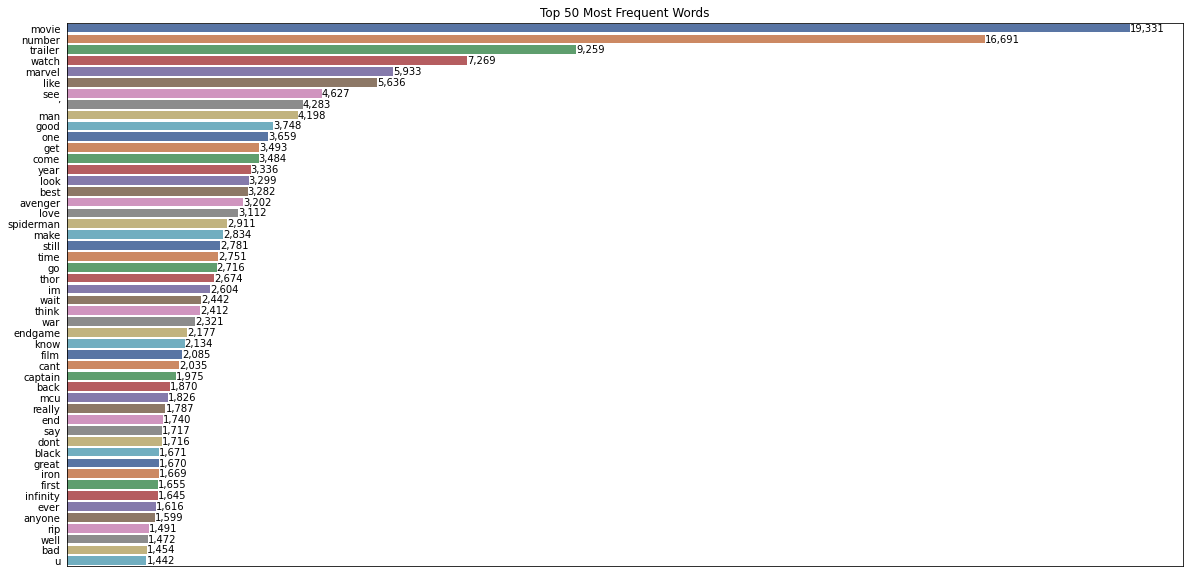

In [266]:
# compile list of words and counts for top 50 most frequent words
words_and_counts = Counter(' '.join(df_comments['comment_cleaned']).lower().split()).most_common(50)
words = [word for word, _ in words_and_counts]
counts = [count for _, count in words_and_counts]

fig, axs = create_plots()

g = sns.barplot(x = counts, y = words, palette = 'deep')

clean_plot(axs, g, title = 'Top 50 Most Frequent Words')
plt.show()

We see some familiar words for marvel: "avenger", "spiderman", "thor", "captain", "endgame", "infinity". Let's use a word cloud to represent the same words.

In [270]:
words_and_counts = Counter(' '.join(df_comments['comment_cleaned']).split()).most_common(1000)
words = [word for word, _ in words_and_counts]
counts = [count for _, count in words_and_counts]

In [272]:
# load marvel logo and convert to black and white
marvel_mask = np.array(Image.open('Marvel_Logo.svg.png'))
vectorized_threshold = np.vectorize(lambda val: 255 if val < 1 else 0)
marvel_mask = vectorized_threshold(marvel_mask)

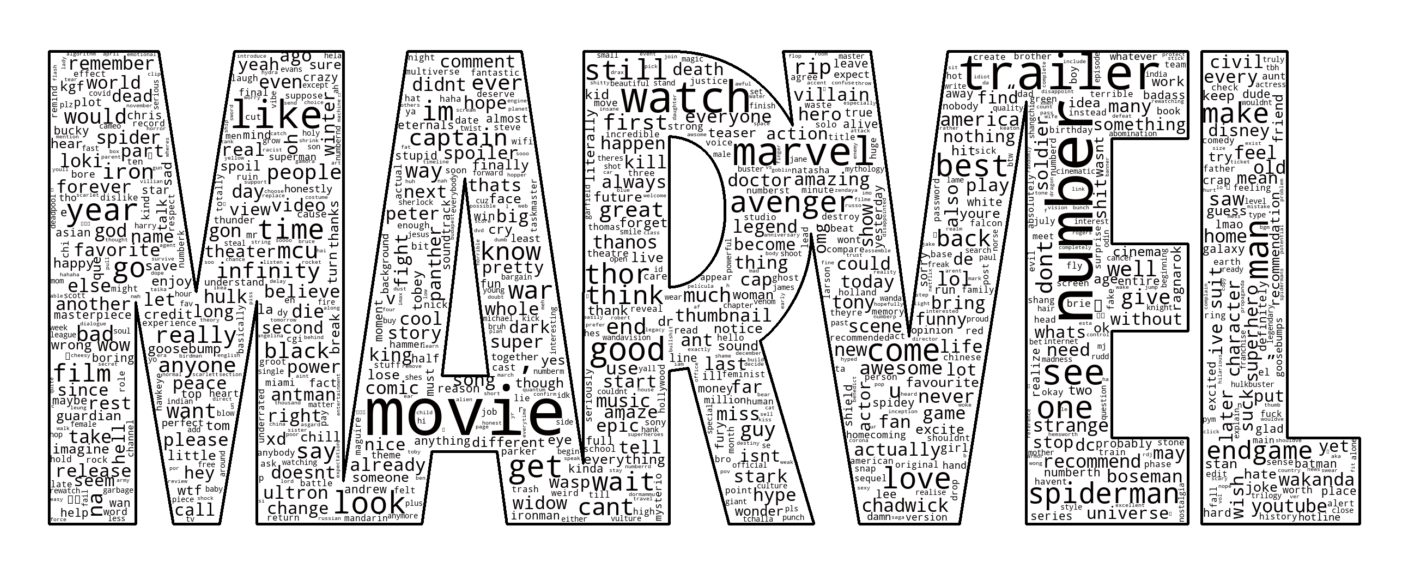

In [273]:
# change font color
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

word_cloud = WordCloud(background_color = 'white', width = 5000, \
    height = 3000, max_words = 1000, mask = marvel_mask, \
        contour_width = 5, contour_color = 'black').generate_from_frequencies({word:count for word, count in zip(words, counts)})

word_cloud.recolor(color_func = black_color_func)
plt.figure(figsize = [25,15])
plt.imshow(word_cloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

The word cloud above shows the top 1000 most common words; now we see even more familiar words! "universe", "ultron", and "ragnarok" to name a few.

## Sentiment Analysis

Now we will create two columns from the *comment_lemmatized_only* feature of our dataset: polarity and subjectivity.

The **polarity** of a comment defines how *positive* or *negative* the comment is. The polarity values range from -1 to + 1; +1 is a high positive polarity and -1 is a high negative polarity. The **subjectivity** of the comment defines how objective or subjective the comment is. The subjectivity values range from 0 to 1; 0 is an objective comment and 1 is a subjective comment.

In [307]:
df_comments['comment_subjectivity'] = df_comments['comment_lemmatized_only'].apply(lambda comment: TextBlob(comment).sentiment.subjectivity)
df_comments['comment_polarity'] = df_comments['comment_lemmatized_only'].apply(lambda comment: TextBlob(comment).sentiment.polarity)

def add_label(score):
    if type(score) == str:
        return 'Neutral'
    elif score > 0:
        return 'Positive'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Negative'

df_comments['comment_label'] = df_comments['comment_polarity'].apply(add_label)

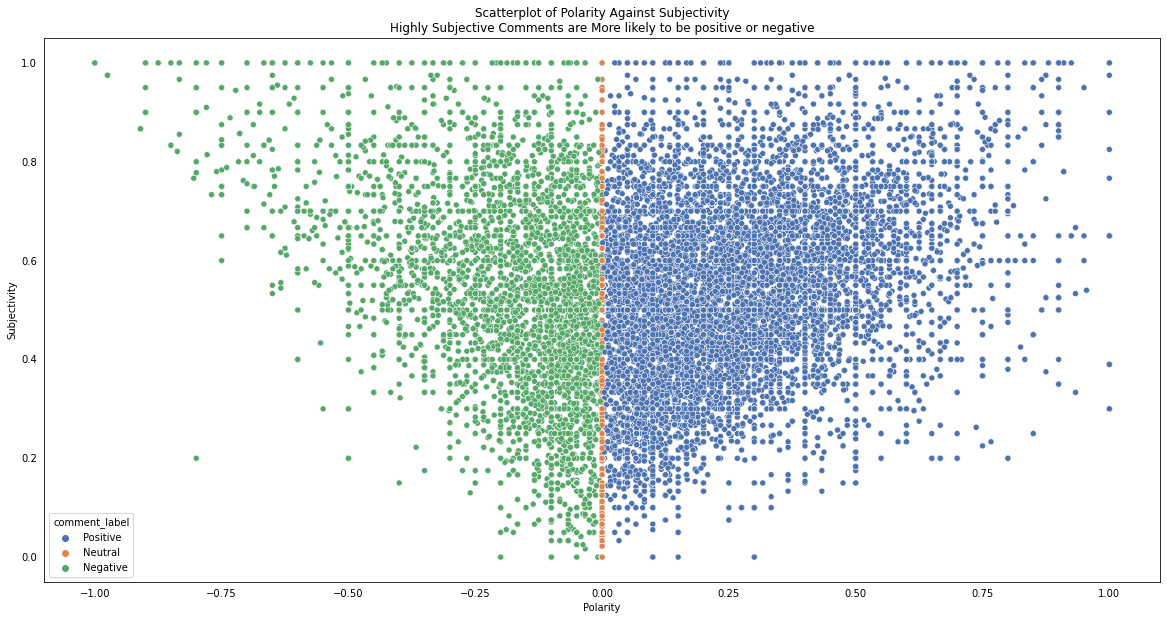

In [308]:
fig, axs = create_plots()
g = sns.scatterplot(data = df_comments, x = 'comment_polarity', y = 'comment_subjectivity', hue = 'comment_label', palette = 'deep')
g.set(ylabel = 'Subjectivity', xlabel = 'Polarity', title = 'Scatterplot of Polarity Against Subjectivity\nHighly Subjective Comments are More likely to be positive or negative')
plt.tick_params(left = False, bottom = False)
plt.show()

Which movie has the highest polarity score overall?

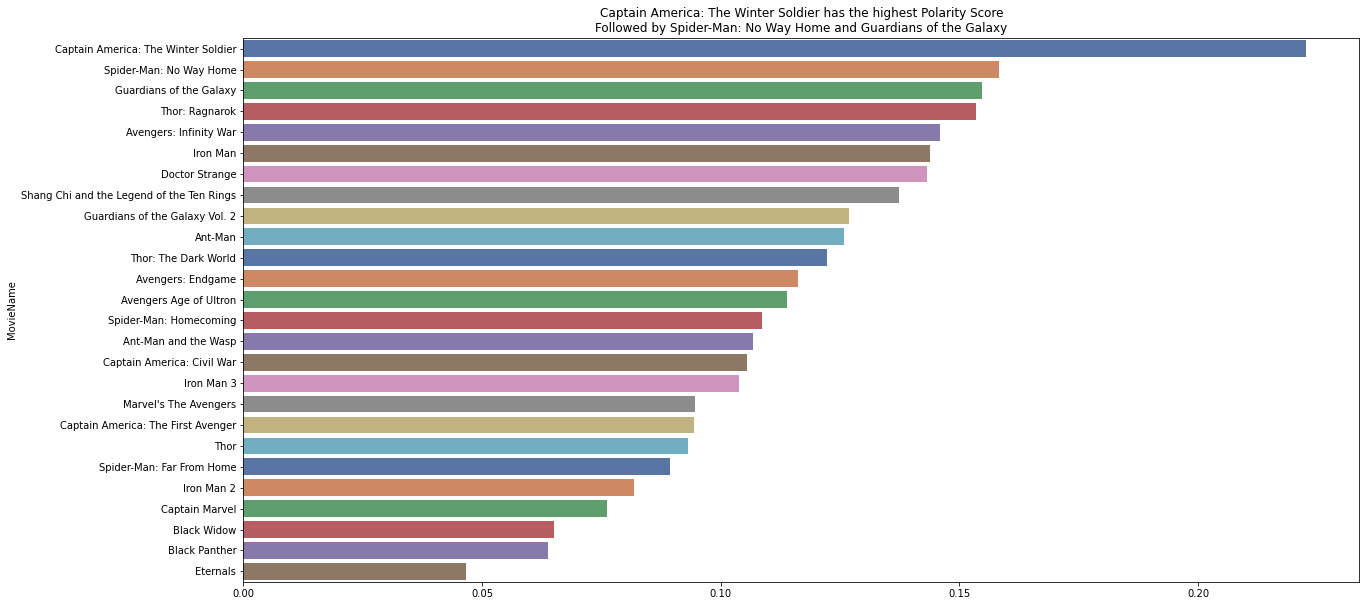

In [309]:
# group movies and find avg polarity
movies_grouped = df_comments.groupby(by = 'MovieName')['comment_polarity'].mean().reset_index(name = 'avg_polarity')
movies_grouped['overall_label'] = movies_grouped['avg_polarity'].apply(add_label)

fig, axs = create_plots()
g = sns.barplot(data = movies_grouped, x = 'avg_polarity', y = 'MovieName', order = movies_grouped.sort_values(by = 'avg_polarity', ascending = False)['MovieName'].values,\
    palette = 'deep')
g.set(title = 'Captain America: The Winter Soldier has the highest Polarity Score\nFollowed by Spider-Man: No Way Home and Guardians of the Galaxy', xlabel = None)
plt.show()

By looking at the plot above, we can see that Captain America: The Winter Solider has the highest polarity score; this makes sense because this Captain America movie was highly anticipated. We can see that Eternals had the lowest score; this is one of Marvel's most recent movies and wasn't received very well at the box office. Let's see the negative reviews for Eternals to see what we can learn.

In [310]:
eternals_bad_comments = df_comments[(df_comments['MovieName'] == 'Eternals') & (df_comments['comment_label'] == 'Negative')]\
    .sort_values(by = 'comment_polarity', ascending = True)['OriginalComment'].iloc[:5]
for ind,comment in enumerate(eternals_bad_comments):
    print(ind, comment)

0 Boring movie
1 Worst and depressive movie ever dont watch! Makes you depressed!
2 this movie has some boring scenes....
3 This movie looks like it is going to be terrible.
4 Its a DISGUSTING movie men......save your money -let the perverted run with their shame and remember ....that lake of fire is "eternal".


Wow, those are some pretty bad comments! The thing about these comments is that they are mostly addressing the content of the movie and not the content of the trailer. 

What about for Black Panther? I personally was a big fan of the movie, but perhaps the trailer wasn't very great. Let's see what the worst comments had to say.

In [311]:
black_pather_bad_comments = df_comments[(df_comments['MovieName'] == 'Black Panther') & (df_comments['comment_label'] == 'Negative')]\
    .sort_values(by = 'comment_polarity', ascending = True)['OriginalComment'].iloc[:5]
for ind,comment in enumerate(black_pather_bad_comments):
    print(ind, comment)

0 who is here after the horrible news 






Rip chadwick
1 I cannot believe how horrible 2020 is. Rest In Peace Chadwick Boseman, you were a king. 💙🙏
2 I can't believe he is gone! Life can be so cruel!
3 Anyone here after the terrible news? 🕊 RIP
4 Why 2020 is so cruel ?


Interesting, the 5 "worst" comments in for Black Panther are mostly addressing the passing of Chadwick Boseman. This does not have anything to do with the quality of the movie, but the "negative" polarity of people grieving in the comments section is skewing the data.

Let's see what the positive comments say.

In [312]:
black_pather_good_comments = df_comments[(df_comments['MovieName'] == 'Black Panther') & (df_comments['comment_label'] == 'Positive')]\
    .sort_values(by = 'comment_polarity', ascending = False)['OriginalComment'].iloc[:5]
for ind,comment in enumerate(black_pather_good_comments):
    print(ind, comment)

0 Best trailer in MCU
1 Earth just lost her best defender
2 Best trailer in history- RIP Tchala
3 Except for the infinity war trailer I think this is the best one they ever made
4 Rip he is a best actor Hollywood 😢


Now we are seeing comments that actually adress the trailer; these comments are saying something nice about the trailer and also addressing the passing of the actor at the same time.

### Sentiment Using Original Comments

Let's see how the results change when we pass the original comments - without removing stopwords or lemmatizing the words.

In [313]:
# sentiment using original comment
df_comments['comment_subjectivity_original'] = df_comments['OriginalComment'].apply(lambda comment: TextBlob(comment).sentiment.subjectivity)
df_comments['comment_polarity_original'] = df_comments['OriginalComment'].apply(lambda comment: TextBlob(comment).sentiment.polarity)
df_comments['comment_label_original'] = df_comments['OriginalComment'].apply(add_label)

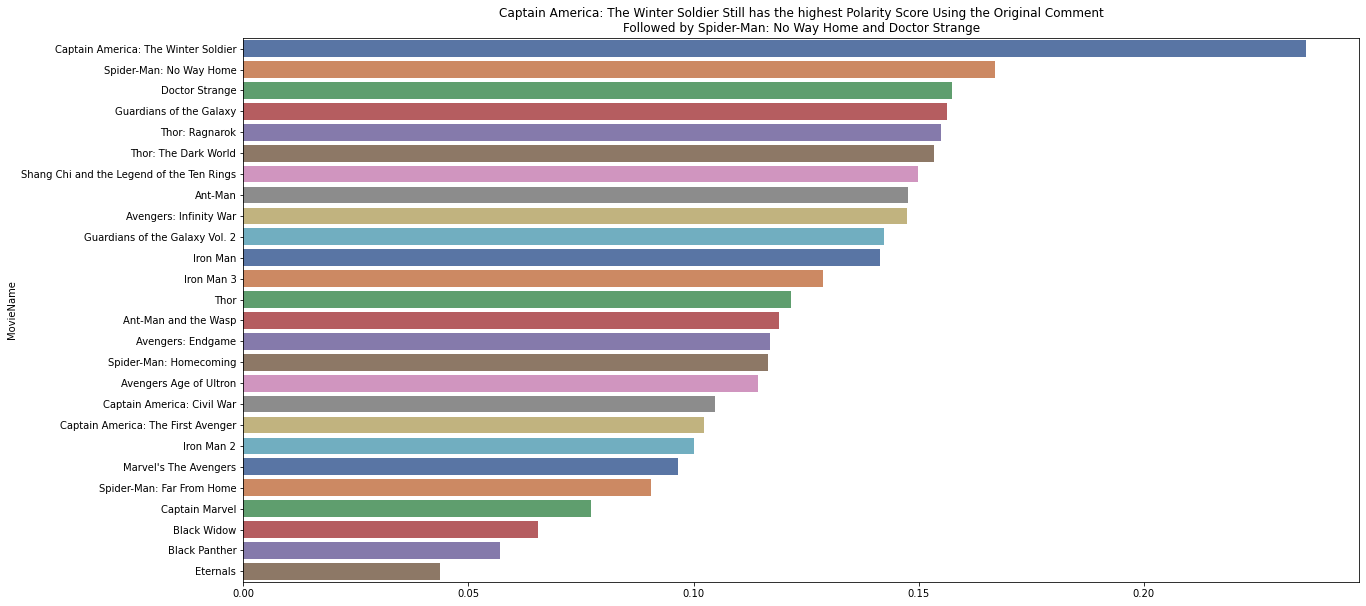

In [316]:
# group movies and find avg polarity
movies_grouped_original = df_comments.groupby(by = 'MovieName')['comment_polarity_original'].mean().reset_index(name = 'avg_polarity')
movies_grouped_original['overall_label'] = movies_grouped_original['avg_polarity'].apply(add_label)

fig, axs = create_plots()
g = sns.barplot(data = movies_grouped_original, x = 'avg_polarity', y = 'MovieName', order = movies_grouped_original.sort_values(by = 'avg_polarity', ascending = False)['MovieName'].values,\
    palette = 'deep')
g.set(title = 'Captain America: The Winter Soldier Still has the highest Polarity Score Using the Original Comment\nFollowed by Spider-Man: No Way Home and Doctor Strange', xlabel = None)
plt.show()

As we can see from the plot above, the polarity of the movies doesn't change much when we use the original comment.

Let's look at the most positive reviews from Captain America: The Winter Soldier to see what the fans were most interested in.

In [317]:
cap_america_good_comments = df_comments[(df_comments['MovieName'] == 'Captain America: The Winter Soldier') & (df_comments['comment_label'] == 'Positive')]\
    .sort_values(by = 'comment_polarity', ascending = False)['OriginalComment'].iloc[:5]
for ind,comment in enumerate(cap_america_good_comments):
    print(ind, comment)

0 I can't wait. Rotten Tomatoes is at 92% with this movie, it seems the comedy is downplayed and the story goes all the way like a spy thriller, just like Ed Brubaker's run was! Awesome!
1 Best mcu film
2 best marvel movie ever
3 Awesome video!!
4 best Movie


The comment first comment shows lots of excitement, which explains the high polarity score.

On the topic of emotions in the data, let's see if we can extract more granular emotions from the comments instead of just "positive", "negative" and "neutral".

## Text2Emotion